In [1]:
## Analysis
import numpy as np
import scipy as sp
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Load data

In [3]:
df_exp = pd.read_csv('../data/GSE1730_processed.csv')

In [4]:
df_exp.dropna(how='any', inplace=True)

In [5]:
df_exp = df_exp[df_exp.RSD < 1][['GENE', 'mean_exp']]

In [6]:
df_exp = df_exp.rename(columns={"GENE": "gene"})

In [7]:
df_genes = pd.read_csv('../data/ecoli_gene_data.csv')

In [8]:
df = df_genes.merge(df_exp, how='left')

In [9]:
df.dropna(how='any', inplace=True)

## Analysing explanatory variables

In [10]:
elements = ['CDS', '3UTR', '5UTR', 'promoter']
NTs = ['A', 'T', 'G', 'C']

In [11]:
df_summary = pd.DataFrame(columns=['element', 'nt', 'freq'])
for e in elements:
    for nt in NTs:
        meanfreq = np.mean(df['freq' + str(nt) + '_' + str(e)])
        df_summary = df_summary.append({'element': e, 'nt': nt, 'freq': meanfreq},
                                       ignore_index=True)

In [12]:
df_summary_pivoted = df_summary.pivot('nt', 'element', 'freq')
df_summary_pivoted = df_summary_pivoted.reindex(index=NTs, columns=elements)

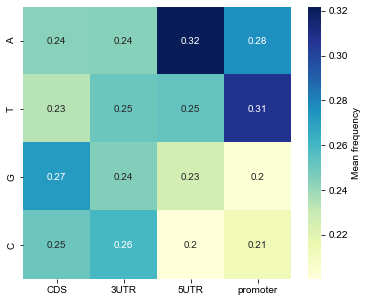

In [13]:
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(df_summary_pivoted, annot=True, cmap="YlGnBu",
            cbar_kws={'label': 'Mean frequency'})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()

## Building DT using all explanatory variables

In [14]:
exp_all = df.columns.to_list()[8:-1]

In [15]:
explanatory = exp_all
response = 'mean_exp'

In [16]:
X = df[explanatory]
y = df[response]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [18]:
tree = DecisionTreeRegressor(max_depth=10)
tree.fit(X_train, y_train)
y_predicted = tree.predict(X_test)

In [19]:
linreg = sp.stats.linregress(np.log10(y_predicted), np.log10(y_test))

In [20]:
r2 = linreg.rvalue**2
r2

0.46488924131788756

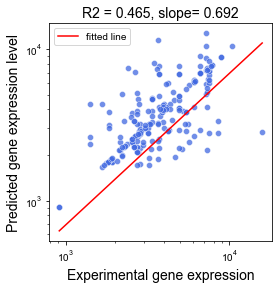

In [21]:
fig, ax = plt.subplots(figsize=(4,4))
sns.scatterplot(y_predicted, y_test, alpha=0.75, color='royalblue')
ax.plot(np.sort(y_predicted), linreg.intercept + linreg.slope*np.sort(y_predicted), 'r', label='fitted line')
ax.set_yscale('log')
ax.set_xscale('log')
plt.legend()
plt.ylabel('Predicted gene expression level', fontsize=14)
plt.xlabel('Experimental gene expression', fontsize=14)
plt.title('R2 = {:.3f}, slope= {:.3f}'.format(r2, linreg.slope), fontsize=14)
plt.show()

## Weights of explanatory variables

In [23]:
featimpt = tree.feature_importances_
featimpt

array([0.17959964, 0.16649791, 0.03378055, 0.05349351, 0.12953024,
       0.0085554 , 0.06619862, 0.01628959, 0.01684498, 0.00033769,
       0.00985185, 0.01836969, 0.04259658, 0.04993108, 0.03622571,
       0.08845917, 0.01497371, 0.03027526, 0.        , 0.01366206,
       0.00310116, 0.00900808, 0.00446859, 0.00794893])

In [31]:
featimpt_dict = dict(zip(exp_all, featimpt))

In [28]:
elements = ['CDS', '3UTR', '5UTR', 'promoter']
attributes = ['len', 'freqA', 'freqT', 'freqG', 'freqC', 'freqGC']

In [34]:
df_summary = pd.DataFrame(columns=['element', 'attribute', 'impt'])
for e in elements:
    for a in attributes:
        colname = str(a) + '_' + str(e)
        meanfreq = np.mean(df[colname])
        df_summary = df_summary.append({'element': e, 'attribute': a, 'impt': featimpt_dict[colname]},
                                       ignore_index=True)

In [38]:
df_summary_pivoted = df_summary.pivot('attribute', 'element', 'impt')
df_summary_pivoted = df_summary_pivoted.reindex(index=attributes, columns=elements)

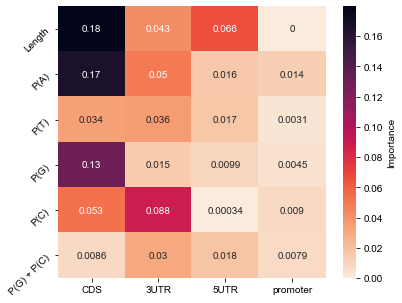

In [60]:
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(df_summary_pivoted, annot=True, cmap=sns.cm.rocket_r,
            cbar_kws={'label': 'Importance'},
            yticklabels=['Length', 'P(A)', 'P(T)', 'P(G)', 'P(C)', 'P(G) + P(C)'])
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_xlabel('')
ax.set_ylabel('')
plt.yticks(rotation=45)
plt.show()

In [50]:
featimpt_sorted = sorted(range(len(featimpt)), key=lambda k: featimpt[k], reverse=True)

In [51]:
sorted_feats = []
for i in featimpt_sorted:
    sorted_feats.append(exp_all[i])

In [52]:
sorted_feats

['len_CDS',
 'freqA_CDS',
 'freqG_CDS',
 'freqC_3UTR',
 'len_5UTR',
 'freqC_CDS',
 'freqA_3UTR',
 'len_3UTR',
 'freqT_3UTR',
 'freqT_CDS',
 'freqGC_3UTR',
 'freqGC_5UTR',
 'freqT_5UTR',
 'freqA_5UTR',
 'freqG_3UTR',
 'freqA_promoter',
 'freqG_5UTR',
 'freqC_promoter',
 'freqGC_CDS',
 'freqGC_promoter',
 'freqG_promoter',
 'freqT_promoter',
 'freqC_5UTR',
 'len_promoter']

In [53]:
explanatory = sorted_feats[:5]
response = 'mean_exp'

In [54]:
X = df[explanatory]
y = df[response]

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [56]:
tree = DecisionTreeRegressor(max_depth=10)
tree.fit(X_train, y_train)
y_predicted = tree.predict(X_test)

In [57]:
linreg = sp.stats.linregress(np.log10(y_predicted), np.log10(y_test))

In [58]:
r2 = linreg.rvalue**2
r2

0.34594615526630423

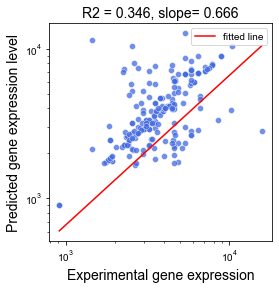

In [59]:
fig, ax = plt.subplots(figsize=(4,4))
sns.scatterplot(y_predicted, y_test, alpha=0.75, color='royalblue')
ax.plot(np.sort(y_predicted), linreg.intercept + linreg.slope*np.sort(y_predicted), 'r', label='fitted line')
ax.set_yscale('log')
ax.set_xscale('log')
plt.legend()
plt.ylabel('Predicted gene expression level', fontsize=14)
plt.xlabel('Experimental gene expression', fontsize=14)
plt.title('R2 = {:.3f}, slope= {:.3f}'.format(r2, linreg.slope), fontsize=14)
plt.show()

## Information on 3' UTR

In [10]:
explanatory = ['len_3UTR', 'freqA_3UTR', 'freqT_3UTR', 'freqC_3UTR', 'freqG_3UTR','freqGC_3UTR']
response = 'mean_exp'

In [11]:
X = df[explanatory]
y = df[response]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [13]:
tree = DecisionTreeRegressor(max_depth=10)
tree.fit(X_train, y_train)
y_predicted = tree.predict(X_test)

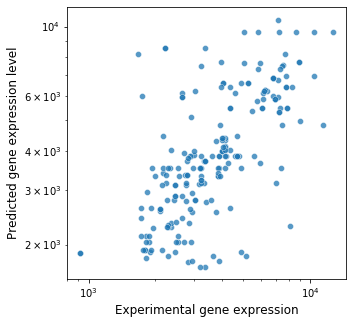

In [14]:
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(y_test, y_predicted, alpha=0.75)
ax.set_yscale('log')
ax.set_xscale('log')
plt.ylabel('Predicted gene expression level', fontsize=12)
plt.xlabel('Experimental gene expression', fontsize=12)
plt.show()

In [15]:
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(y_test, y_predicted)

In [16]:
r_value

0.6556797426552616